In [333]:
# Работа с файлами и системными путями
import os  # Работа с операционной системой и файловыми путями
import warnings  # Управление предупреждениями
warnings.filterwarnings("ignore")    
import tqdm as notebook_tqdm # Новые шкалы прогресса
#импортируем используемые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
# Работа с пропусками
import missingno as msno
#Работа с датой и временем
from datetime import datetime

#библиотека для расчета коэффициентов корреляции Фи
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

import sklearn

# для разделения выборки
from sklearn.model_selection import train_test_split

# Создание пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# кодировщики
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    LabelEncoder,
    RobustScaler
)

# инструмент для автоподбора гиперпараметров
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# метрики
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, 
    recall_score, precision_score,
    f1_score, mean_absolute_percentage_error                        
    )

# импортируем модели
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier  # Энсамблевые методы
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor  # Энсамблевые методы
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, mutual_info_regression  # Отбор признаков
import xgboost as xgb  # XGBoost модель
import lightgbm as lgb  # LightGBM модель
import catboost as cb  # CatBoost модель
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
# Анализ важности признаков
from sklearn.inspection import permutation_importance
import shap

In [334]:
#Для загрузки с яндекс диска
import requests
import urllib
import json
import zipfile
from urllib.parse import urlencode

In [335]:
import joblib

In [336]:
import optuna
from optuna import distributions
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution

In [337]:
#Константы
#Я просто любитель комикса, поэтому 42 :)
RANDOM_STATE = 42

#Выборку будем делить в отношении 3:1 - 3 обучающей, 1 доля тестовой
TEST_SIZE = 0.25

<a id='Step0'></a>
<h3><b> Функции, используемые в проекте<a class="tocSkip"></h3>

In [338]:
#Функция для отображения основной информации по датафрейму и количество пропусков

def check_df (dataframes):
    for df in dataframes:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print(f'Общая информация по датафрейму {df_name}:')
        # общая информация
        df.info()
        # описательная статистика
        display(df.describe())
        # первые 5 строк
        display(df.head())
        print()
        print(f'В датафрейме {df_name}:')
        print(f'Количество пропущенных значений:\n{df.isna().sum()} \
        \nКоличество явных дубликатов: {df.duplicated().sum()}')
        print()

In [339]:
#Функция проверки на пропущенные значения и явные дубликаты

def check_isna_dupl (dataframes):
    for df in dataframes:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print(f'В датафрейме {df_name}:')
        print(f'Количество пропущенных значений:\n{df.isna().sum()} \
        \nКоличество явных дубликатов: {df.duplicated().sum()}')
        print()

In [340]:
def load_data (file_path):
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, sep=',')
        print('Данные успешно загружены')
        return df
    else:
        print('Something is wrong')

In [341]:
#Функция построения графика гистограмм распределения

def histogram(df, col, target, lim):
    sns.histplot(df, bins=20, kde=True, hue=target, x=col, xlim=c(0, 100))
    plt.title(f'Рапределение по {col}', fontsize=16)
    plt.ylabel('Количество', fontsize=14)

In [342]:
#Функция построения графика распределения признаков

def categoral_unique(df, col, target):   
    plt.figure(figsize=(8,6))
    plot = sns.countplot(y=col, data=df, hue=target)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_xlabel('Количество', fontsize=14)

<a id='Step1'></a>
<h3><b> 1. Загрузка данных<a class="tocSkip"></h3>

In [343]:
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
api = KaggleApi()
api.authenticate()

In [344]:
#os.system('kaggle competitions download -c ds-rs-45')

In [44]:
zip_path = ('C:/Users/adzen/Documents/YandexPracticum/Kaggle_Final_45/ds-rs-45.zip')

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./data')

In [345]:
train_pth = './data/train.csv'
test_pth = './data/test.csv'

In [346]:
df_train = load_data(train_pth)
df_test = load_data(test_pth)

Данные успешно загружены
Данные успешно загружены


In [347]:
check_df([df_train, df_test])

Общая информация по датафрейму df_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412590 entries, 0 to 412589
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               412590 non-null  object 
 1   Additional_Number_of_Scoring                412590 non-null  int64  
 2   Review_Date                                 412590 non-null  object 
 3   Hotel_Name                                  412590 non-null  object 
 4   Reviewer_Nationality                        412590 non-null  object 
 5   Negative_Review                             412590 non-null  object 
 6   Review_Total_Negative_Word_Counts           412590 non-null  int64  
 7   Total_Number_of_Reviews                     412590 non-null  int64  
 8   Positive_Review                             412590 non-null  object 
 9   Review_Total_Positive_Word_Co

,Additional_Number_of_Scoring,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng
count,412590.000000,412590.000000,412590.000000,412590.000000,412590.000000,412590.000000,409990.000000,409990.000000
mean,498.012994,18.551618,2744.936336,17.793614,7.166359,8.395058,49.440722,2.826807
std,500.543501,29.663553,2319.361934,21.820234,11.057331,1.637880,3.468718,4.575712
min,1.000000,0.000000,43.000000,0.000000,1.000000,2.500000,41.328376,-0.369758
25%,169.000000,2.000000,1161.000000,5.000000,1.000000,7.500000,48.214277,-0.143372
50%,341.000000,9.000000,2134.000000,11.000000,3.000000,8.800000,51.499981,0.019886
75%,660.000000,23.000000,3633.000000,22.000000,8.000000,9.600000,51.516384,4.834443
max,2682.000000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233


,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,Ndsm Plein 28 Amsterdam Noord 1033 WB Amsterda...,170,4/17/2017,DoubleTree by Hilton Hotel Amsterdam NDSM Wharf,United Kingdom,Too far from attractions Had to use ferry to ...,72,1593,Staff were very helpful Good breakfast,8,1,5.4,"[' Leisure trip ', ' Couple ', ' Queen Guest R...",108 day,52.400181,4.893665
1,Ferdinand Bolstraat 194 Oud Zuid 1072 LW Amste...,114,5/26/2016,Savoy Hotel Amsterdam,Malaysia,Staff should handle customer document during ...,246,995,Very clean and cozy room Friendly and helpful...,41,1,9.6,"[' Leisure trip ', ' Couple ', ' Small Double ...",434 day,52.349743,4.891191
2,18 Albert Embankment Lambeth London SE1 7TJ Un...,1195,12/4/2016,Park Plaza London Riverbank,United Kingdom,The hot breakfast could have been fresher tas...,19,4684,The room was to a high standard The staff wer...,19,3,8.8,"[' Business trip ', ' Solo traveler ', ' Super...",242 day,51.491374,-0.121419
3,Schottenring 24 01 Innere Stadt 1010 Vienna Au...,111,4/30/2017,Palais Hansen Kempinski Vienna,Oman,You have to pay the full amount before arrivi...,14,865,Everything was excellent,5,21,10.0,"[' Leisure trip ', ' Couple ', ' Deluxe Room '...",95 days,48.216315,16.368510
4,Sabino de Arana 22 24 Les Corts 08028 Barcelon...,147,1/22/2017,Catalonia Rigoletto,United Kingdom,All Good,3,1562,The location was excellent for visiting the N...,11,1,9.2,"[' Leisure trip ', ' Family with young childre...",193 day,41.385817,2.125679



В датафрейме df_train:
Количество пропущенных значений:
Hotel_Address                                    0
Additional_Number_of_Scoring                     0
Review_Date                                      0
Hotel_Name                                       0
Reviewer_Nationality                             0
Negative_Review                                  0
Review_Total_Negative_Word_Counts                0
Total_Number_of_Reviews                          0
Positive_Review                                  0
Review_Total_Positive_Word_Counts                0
Total_Number_of_Reviews_Reviewer_Has_Given       0
Reviewer_Score                                   0
Tags                                             0
days_since_review                                0
lat                                           2600
lng                                           2600
dtype: int64         
Количество явных дубликатов: 354

Общая информация по датафрейму df_test:
<class 'pandas.core.frame.DataF

,Additional_Number_of_Scoring,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,lat,lng
count,103148.000000,103148.000000,103148.000000,103148.000000,103148.000000,102480.000000,102480.000000
mean,498.357205,18.490780,2738.974396,17.707837,7.164569,49.449310,2.811787
std,500.520661,29.799785,2309.866121,21.739841,10.971602,3.456744,4.594254
min,1.000000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758
25%,169.000000,2.000000,1164.000000,5.000000,1.000000,48.214662,-0.143671
50%,341.500000,9.000000,2134.000000,11.000000,3.000000,51.500198,-0.000250
75%,660.000000,23.000000,3611.000000,22.000000,8.000000,51.516288,4.820783
max,2682.000000,403.000000,16670.000000,383.000000,297.000000,52.400181,16.429233


,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Tags,days_since_review,lat,lng
0,7 Western Gateway Royal Victoria Dock Newham L...,359,8/14/2015,Novotel London Excel,United Kingdom,No Negative,0,1158,Excellent location for Excel centre Friendly ...,14,5,"[' Leisure trip ', ' Family with young childre...",720 day,51.507720,0.022981
1,Great Cumberland Place Westminster Borough Lon...,1190,8/3/2017,The Cumberland A Guoman Hotel,Gibraltar,No Negative,0,5180,The location was excellent rieally good next ...,11,2,"[' Leisure trip ', ' Group ', ' Standard Doubl...",0 days,51.514879,-0.160650
2,14 Rue de la Sorbonne 5th arr 75005 Paris France,37,4/27/2016,Hotel Mercure La Sorbonne Saint Germain des Pr s,United Kingdom,The beds were uncomfortable We requested a do...,31,464,The buffet breakfast was excellent The breakf...,22,1,"[' Leisure trip ', ' Couple ', ' Standard Doub...",463 day,48.849350,2.343057
3,4 Broad Court Bow Street Covent Garden Westmin...,294,3/3/2016,Fielding Hotel,United Kingdom,No negatives,3,1271,Beautifully appointed room and incredibly pla...,19,12,"[' Leisure trip ', ' Couple ', ' Double Room '...",518 day,51.513931,-0.121989
4,79 81 avenue du Maine 14th arr 75014 Paris France,201,5/2/2016,Holiday Inn Paris Gare Montparnasse,Australia,Not having subtitles on the TV in english,10,3228,Close to transport shops resturants and attra...,18,2,"[' Leisure trip ', ' Couple ', ' Twin Room Non...",458 day,48.838292,2.323019



В датафрейме df_test:
Количество пропущенных значений:
Hotel_Address                                   0
Additional_Number_of_Scoring                    0
Review_Date                                     0
Hotel_Name                                      0
Reviewer_Nationality                            0
Negative_Review                                 0
Review_Total_Negative_Word_Counts               0
Total_Number_of_Reviews                         0
Positive_Review                                 0
Review_Total_Positive_Word_Counts               0
Total_Number_of_Reviews_Reviewer_Has_Given      0
Tags                                            0
days_since_review                               0
lat                                           668
lng                                           668
dtype: int64         
Количество явных дубликатов: 21



Визуализируем пропуски в тренировочном и тестовом датафреймах

Пропущенные значения в тренировочном наборе данных
lat    2600
lng    2600
dtype: int64


Визуализация пропусков


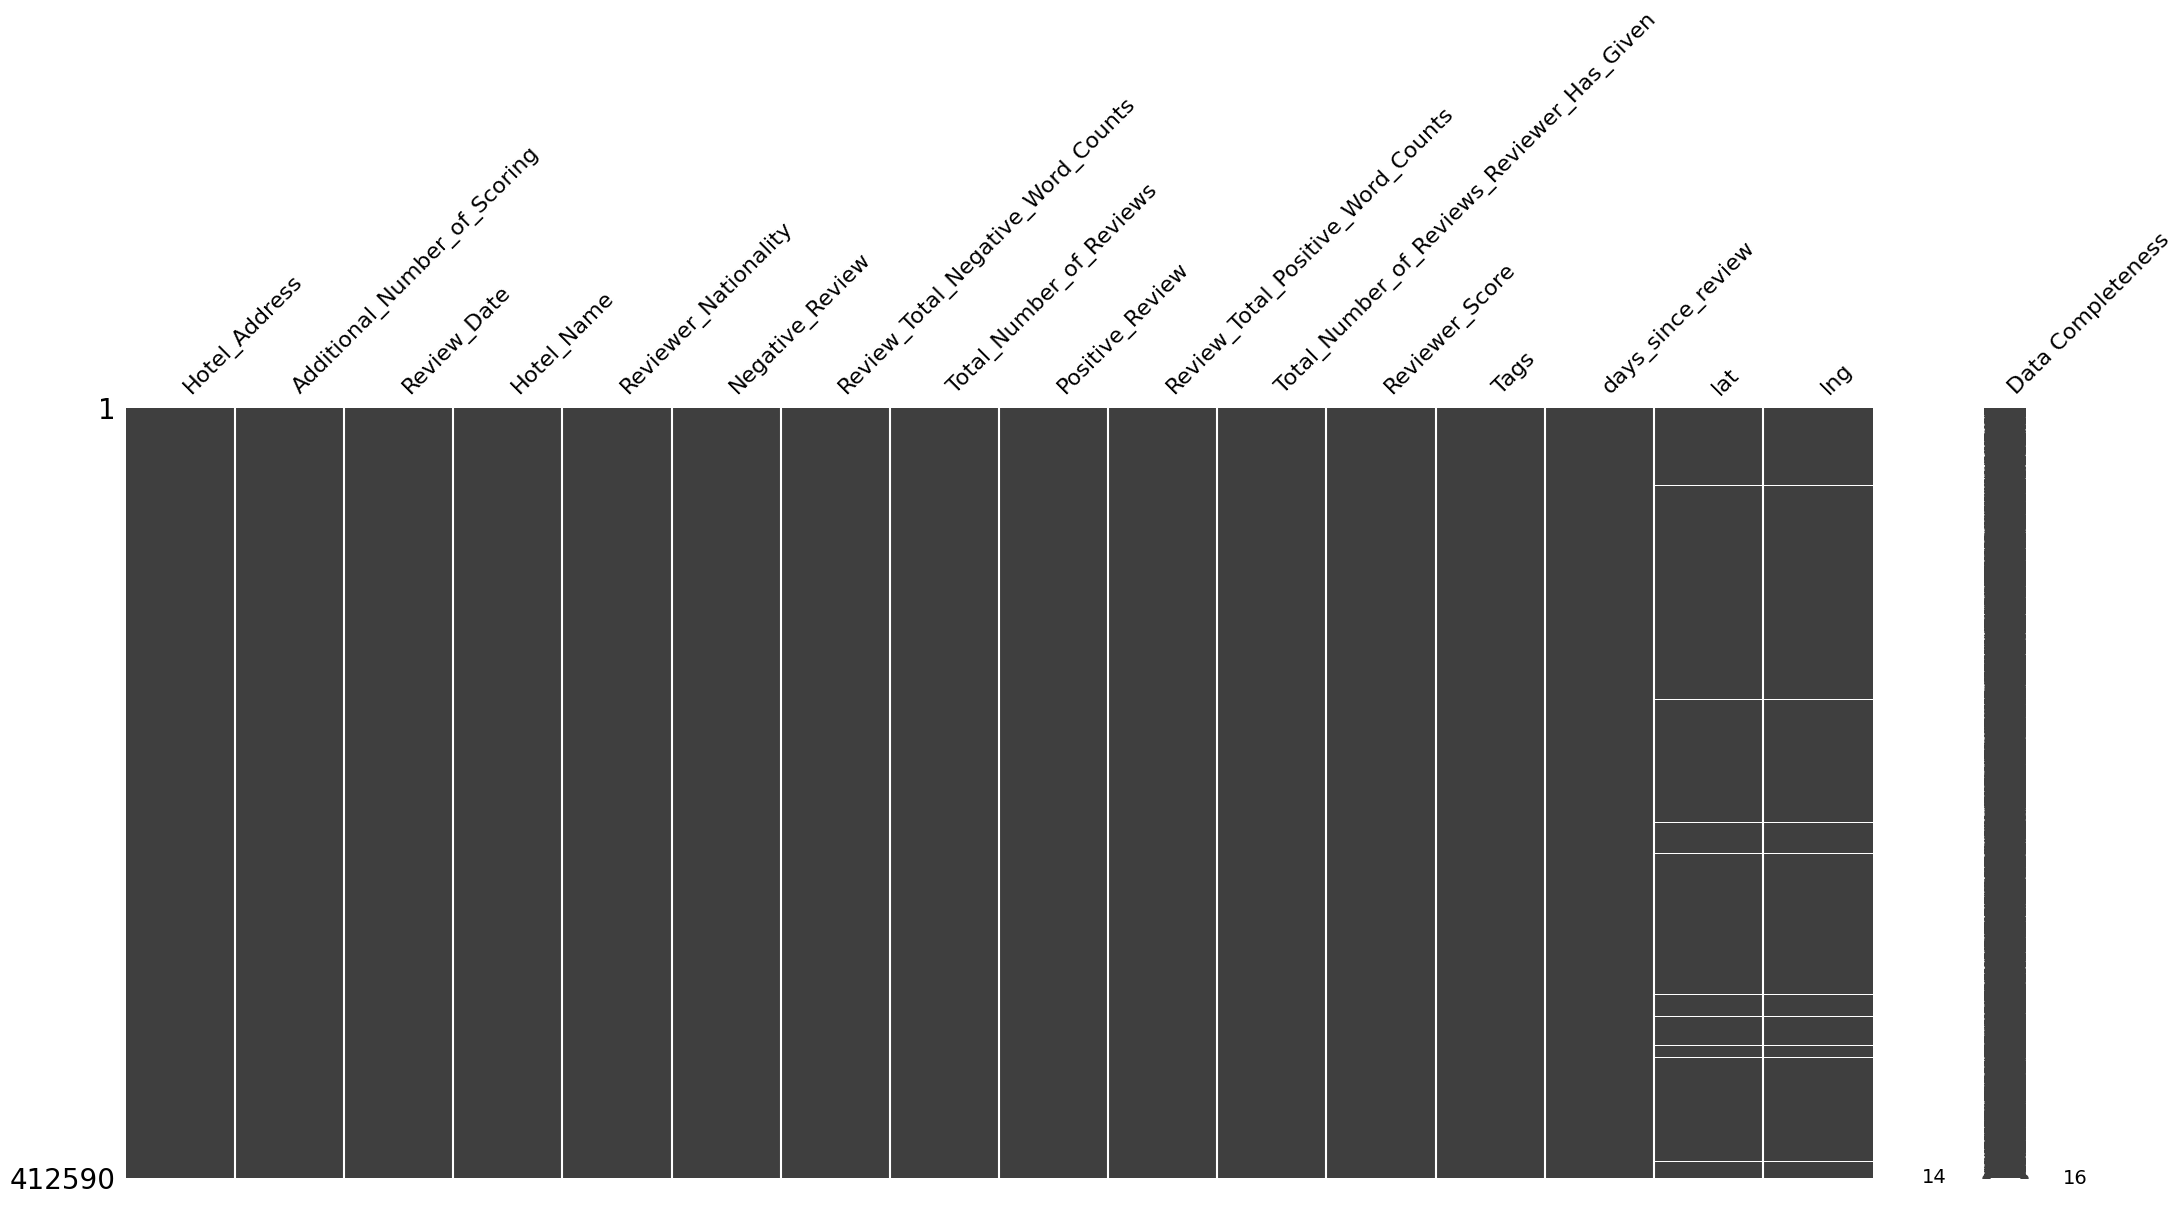

In [348]:
# Проверка на пропуски в тренировочном наборе данных
print('Пропущенные значения в тренировочном наборе данных')
missing_train = df_train.isnull().sum()
print(missing_train[missing_train > 0])
print("\n")
print('Визуализация пропусков')
msno.matrix(df_train, labels=True)
plt.show()

Пропущенные значения в тестовом наборе данных
lat    668
lng    668
dtype: int64


Визуализация пропусков


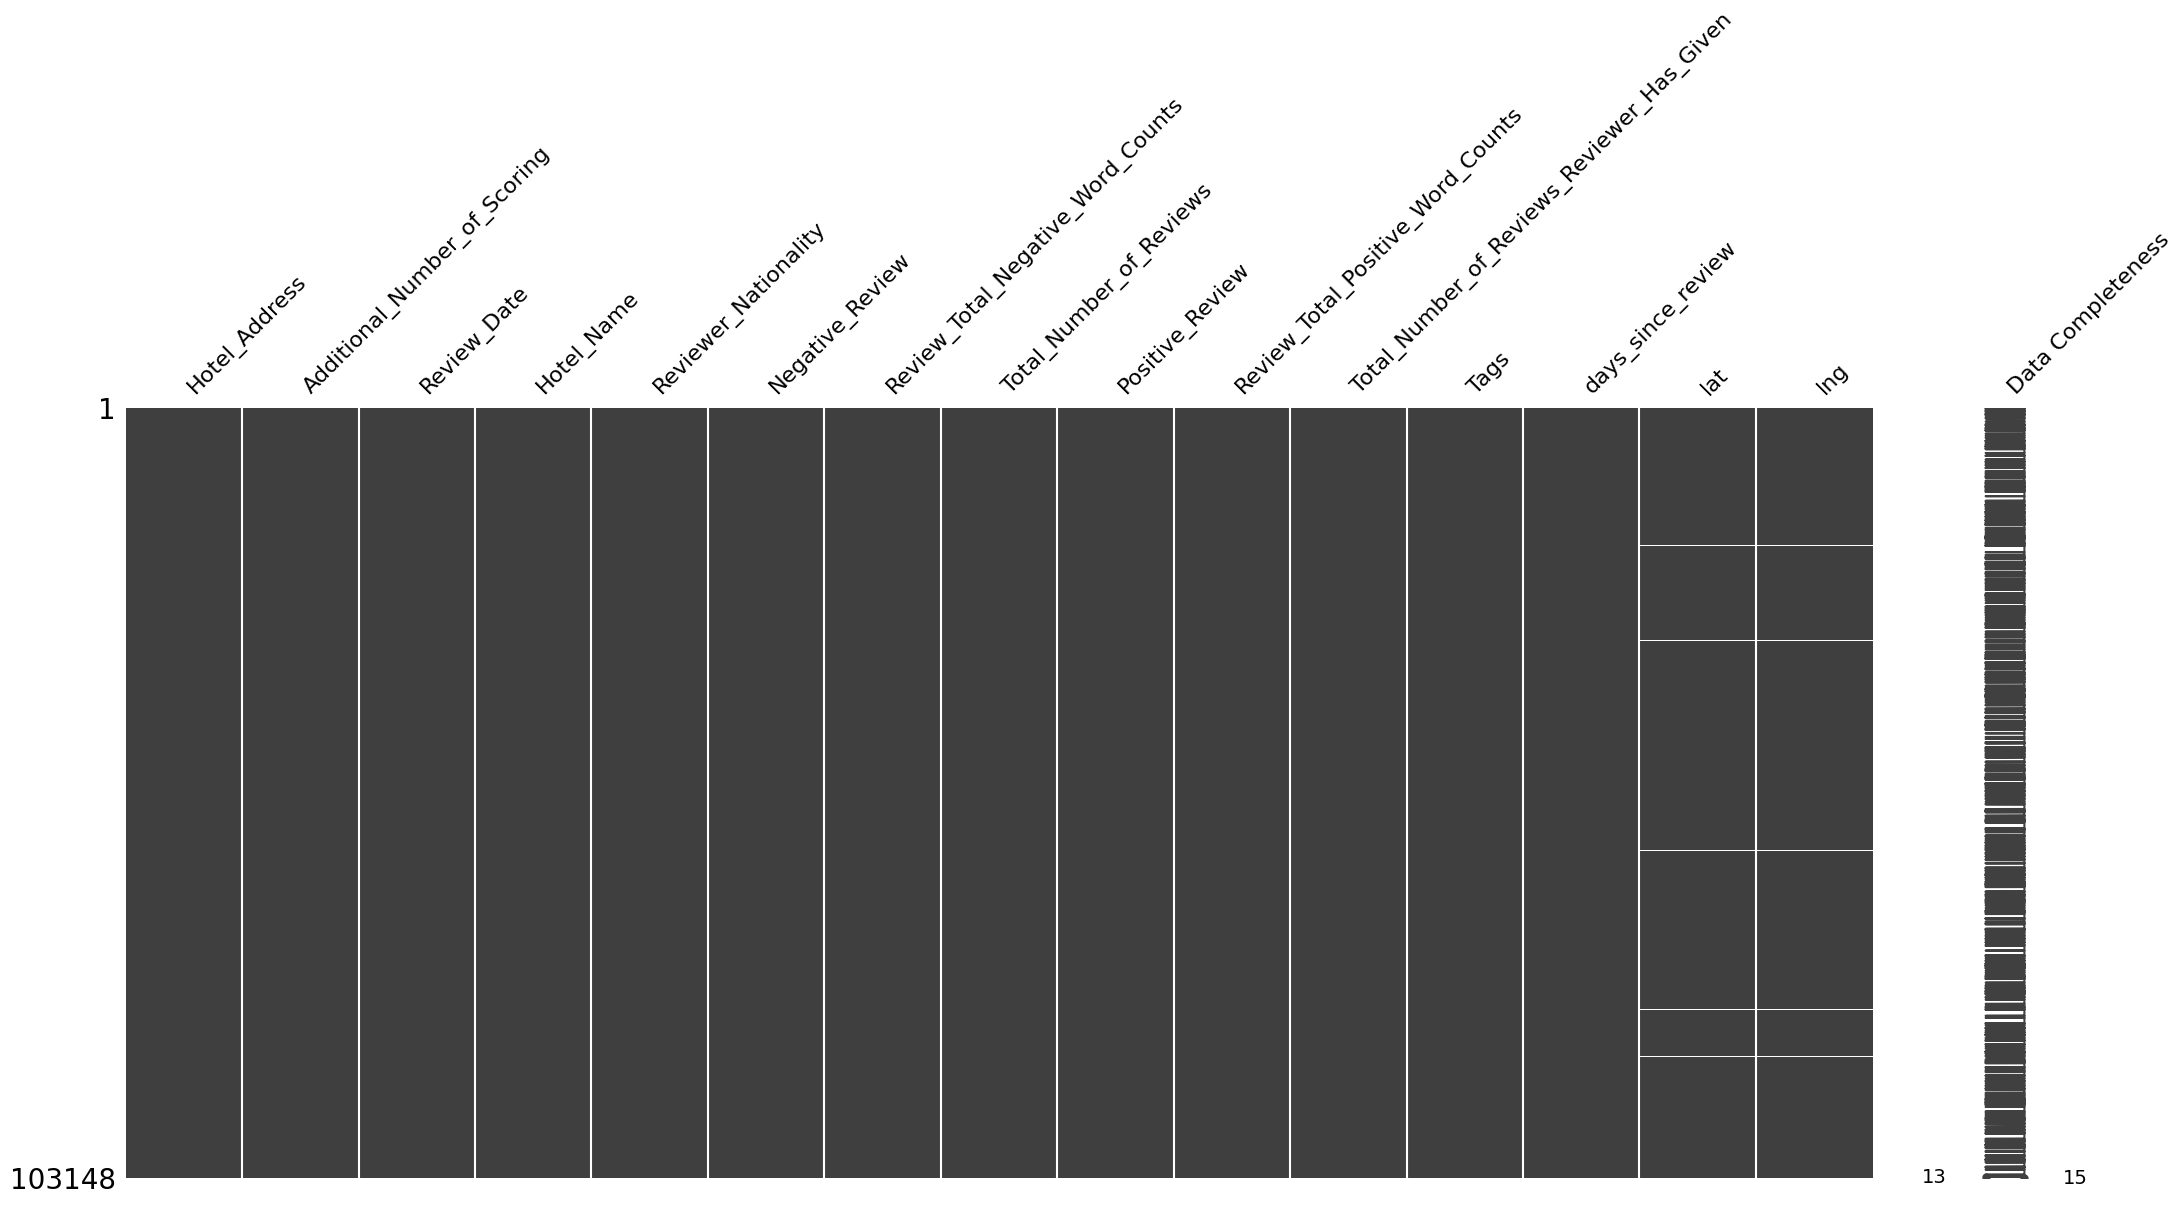

In [349]:
print('Пропущенные значения в тестовом наборе данных')
missing_test = df_test.isnull().sum()
print(missing_test[missing_test > 0])
print("\n")
print('Визуализация пропусков')
msno.matrix(df_test, labels=True)
plt.show()

<a id='Step2'></a>
<h3><b> 2. Предварительная обработка<a class="tocSkip"></h3>

In [350]:
df_train_1 = df_train.copy()
df_test_1 = df_test.copy()

<a id='Step2.3'></a>
<h4><b> 2.3 Проверка на явные дубликаты<a class="tocSkip"></h4>

Повторно проверим на наличие явных дубликатов после заполнения пропусков

In [351]:
print(f'Количество явных дубликатов в df_train: {df_train_1.duplicated().sum()}')
print(f'Количество явных дубликатов в df_test: {df_test_1.duplicated().sum()}')

Количество явных дубликатов в df_train: 354
Количество явных дубликатов в df_test: 21


In [352]:
df_train_2 = df_train_1.copy()
df_test_2 = df_test_1.copy()

<a id='Step2.4'></a>
<h4><b> 2.4 Перевод столбцов в соответствие<a class="tocSkip"></h4>

In [353]:
df_train_2['review_date_normal'] = pd.to_datetime(df_train_2['Review_Date'], format='%m/%d/%Y', errors='coerce')
df_test_2['review_date_normal'] = pd.to_datetime(df_test_2['Review_Date'], format='%m/%d/%Y', errors='coerce')
df_train_2 = df_train_2.drop(columns=['Review_Date'])
df_test_2 = df_test_2.drop(columns=['Review_Date'])
df_train_2['days_since_review_new'] = df_train_2['days_since_review'].str.replace('day', '')
df_train_2['days_since_review_new'] = df_train_2['days_since_review_new'].str.replace(' ', '')
df_train_2['days_since_review_new'] = df_train_2['days_since_review_new'].str.replace('s', '')
df_train_2['days_since_review_new'] = df_train_2['days_since_review_new'].astype('int')
df_test_2['days_since_review_new'] = df_test_2['days_since_review'].str.replace('day', '')
df_test_2['days_since_review_new'] = df_test_2['days_since_review_new'].str.replace(' ', '')
df_test_2['days_since_review_new'] = df_test_2['days_since_review_new'].str.replace('s', '')
df_test_2['days_since_review_new'] = df_test_2['days_since_review_new'].astype('int')
df_train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412590 entries, 0 to 412589
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Hotel_Address                               412590 non-null  object        
 1   Additional_Number_of_Scoring                412590 non-null  int64         
 2   Hotel_Name                                  412590 non-null  object        
 3   Reviewer_Nationality                        412590 non-null  object        
 4   Negative_Review                             412590 non-null  object        
 5   Review_Total_Negative_Word_Counts           412590 non-null  int64         
 6   Total_Number_of_Reviews                     412590 non-null  int64         
 7   Positive_Review                             412590 non-null  object        
 8   Review_Total_Positive_Word_Counts           412590 non-null  int64        

In [354]:
df_train_2.head()

,Hotel_Address,Additional_Number_of_Scoring,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,review_date_normal,days_since_review_new
0,Ndsm Plein 28 Amsterdam Noord 1033 WB Amsterda...,170,DoubleTree by Hilton Hotel Amsterdam NDSM Wharf,United Kingdom,Too far from attractions Had to use ferry to ...,72,1593,Staff were very helpful Good breakfast,8,1,5.4,"[' Leisure trip ', ' Couple ', ' Queen Guest R...",108 day,52.400181,4.893665,2017-04-17,108
1,Ferdinand Bolstraat 194 Oud Zuid 1072 LW Amste...,114,Savoy Hotel Amsterdam,Malaysia,Staff should handle customer document during ...,246,995,Very clean and cozy room Friendly and helpful...,41,1,9.6,"[' Leisure trip ', ' Couple ', ' Small Double ...",434 day,52.349743,4.891191,2016-05-26,434
2,18 Albert Embankment Lambeth London SE1 7TJ Un...,1195,Park Plaza London Riverbank,United Kingdom,The hot breakfast could have been fresher tas...,19,4684,The room was to a high standard The staff wer...,19,3,8.8,"[' Business trip ', ' Solo traveler ', ' Super...",242 day,51.491374,-0.121419,2016-12-04,242
3,Schottenring 24 01 Innere Stadt 1010 Vienna Au...,111,Palais Hansen Kempinski Vienna,Oman,You have to pay the full amount before arrivi...,14,865,Everything was excellent,5,21,10.0,"[' Leisure trip ', ' Couple ', ' Deluxe Room '...",95 days,48.216315,16.368510,2017-04-30,95
4,Sabino de Arana 22 24 Les Corts 08028 Barcelon...,147,Catalonia Rigoletto,United Kingdom,All Good,3,1562,The location was excellent for visiting the N...,11,1,9.2,"[' Leisure trip ', ' Family with young childre...",193 day,41.385817,2.125679,2017-01-22,193


In [355]:
#Преобразованный категориальный признак в количественный
def new_cat_cols(df):
    cat_cols = ['Tags']
    #пересчитаем категории по количеству слов
    df['tags_num'] = df['Tags'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)
    #пересчитаем категории по количеству символов
    df['tags_len'] = df['Tags'].apply(lambda x: len(str(x) if pd.notnull(x) else 0))
    return df
    
df_train_2 = new_cat_cols(df_train_2)
df_test_2 = new_cat_cols(df_test_2)

In [356]:
df_train_3 = df_train_2.drop(columns=['Hotel_Address', 'Hotel_Name', 'Negative_Review', 'Positive_Review', 'Tags', 'days_since_review'])
df_test_3 = df_test_2.drop(columns=['Hotel_Address', 'Hotel_Name', 'Negative_Review', 'Positive_Review', 'Tags', 'days_since_review'])

<a id='Step5'></a>
<h3><b><a id='Step5'></a>5. Корреляционный анализ<a class="tocSkip"></h3>

<a id='Step5.1'></a>
<h4><b> 5.1 Расчет коэффициентов корреляции<a class="tocSkip"></h4>

Коэффициент корреляции Фи, находит взаимосвязь между категориальными, порядковыми и интервальными признаками. Чем ближе его значение по модулю к 1, тем сильнее связь.

- При использовании **phik** настроим параметр **interval_cols**, передав ему список с названиями количественных признаков. 
Phik разделяет признаки на категориальные и количественные автоматически, но часто совершает ошибки, поэтому правильно будет указать все в явном виде.

In [357]:
df_train_3.head()

,Additional_Number_of_Scoring,Reviewer_Nationality,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng,review_date_normal,days_since_review_new,tags_num,tags_len
0,170,United Kingdom,72,1593,8,1,5.4,52.400181,4.893665,2017-04-17,108,5,109
1,114,Malaysia,246,995,41,1,9.6,52.349743,4.891191,2016-05-26,434,5,109
2,1195,United Kingdom,19,4684,19,3,8.8,51.491374,-0.121419,2016-12-04,242,5,121
3,111,Oman,14,865,5,21,10.0,48.216315,16.368510,2017-04-30,95,5,104
4,147,United Kingdom,3,1562,11,1,9.2,41.385817,2.125679,2017-01-22,193,4,96


In [358]:
interval_cols = ['Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews', 'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'lat', 'lng', 'days_since_review_new', 'tags_num', 'tags_len']

In [359]:
# Соберем выборку из 500 записей, для ускорения построения матрицы Фи. Сохраним пропорцию значений целевого признака
df_train_small, _ = train_test_split(
    df_train_3,
    train_size=500,
    stratify=df_train_3['Reviewer_Score'],
    random_state=RANDOM_STATE
)

In [362]:
f_corr_matr = df_train_small.phik_matrix(interval_cols=interval_cols)
f_corr_matr

,Additional_Number_of_Scoring,Reviewer_Nationality,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng,review_date_normal,days_since_review_new,tags_num,tags_len
Additional_Number_of_Scoring,1.000000,0.806586,0.403740,0.993099,0.343938,0.000000,0.000000,0.928786,0.925960,0.927044,0.157932,0.000000,0.260385
Reviewer_Nationality,0.806586,1.000000,0.631628,0.623774,0.000000,0.620548,0.867809,0.565385,0.588875,0.894603,0.206168,0.000000,0.593005
Review_Total_Negative_Word_Counts,0.403740,0.631628,1.000000,0.096275,0.557446,0.000000,0.650767,0.062672,0.000000,0.572317,0.000000,0.000000,0.000000
Total_Number_of_Reviews,0.993099,0.623774,0.096275,1.000000,0.000000,0.000000,0.092247,0.289236,0.311952,0.000000,0.091124,0.000000,0.000000
Review_Total_Positive_Word_Counts,0.343938,0.000000,0.557446,0.000000,1.000000,0.000000,0.000000,0.257954,0.130157,0.330992,0.111732,0.234489,0.000000
Total_Number_of_Reviews_Reviewer_Has_Given,0.000000,0.620548,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.901439,0.054904,0.030000,0.000000
Reviewer_Score,0.000000,0.867809,0.650767,0.092247,0.000000,0.000000,1.000000,0.000000,0.028424,0.000000,0.171418,0.000000,0.000000
lat,0.928786,0.565385,0.062672,0.289236,0.257954,0.000000,0.000000,1.000000,0.873689,0.203700,0.000000,0.000000,0.180532
lng,0.925960,0.588875,0.000000,0.311952,0.130157,0.000000,0.028424,0.873689,1.000000,0.000000,0.154084,0.000000,0.000000
review_date_normal,0.927044,0.894603,0.572317,0.000000,0.330992,0.901439,0.000000,0.203700,0.000000,1.000000,1.000000,0.000000,0.262073


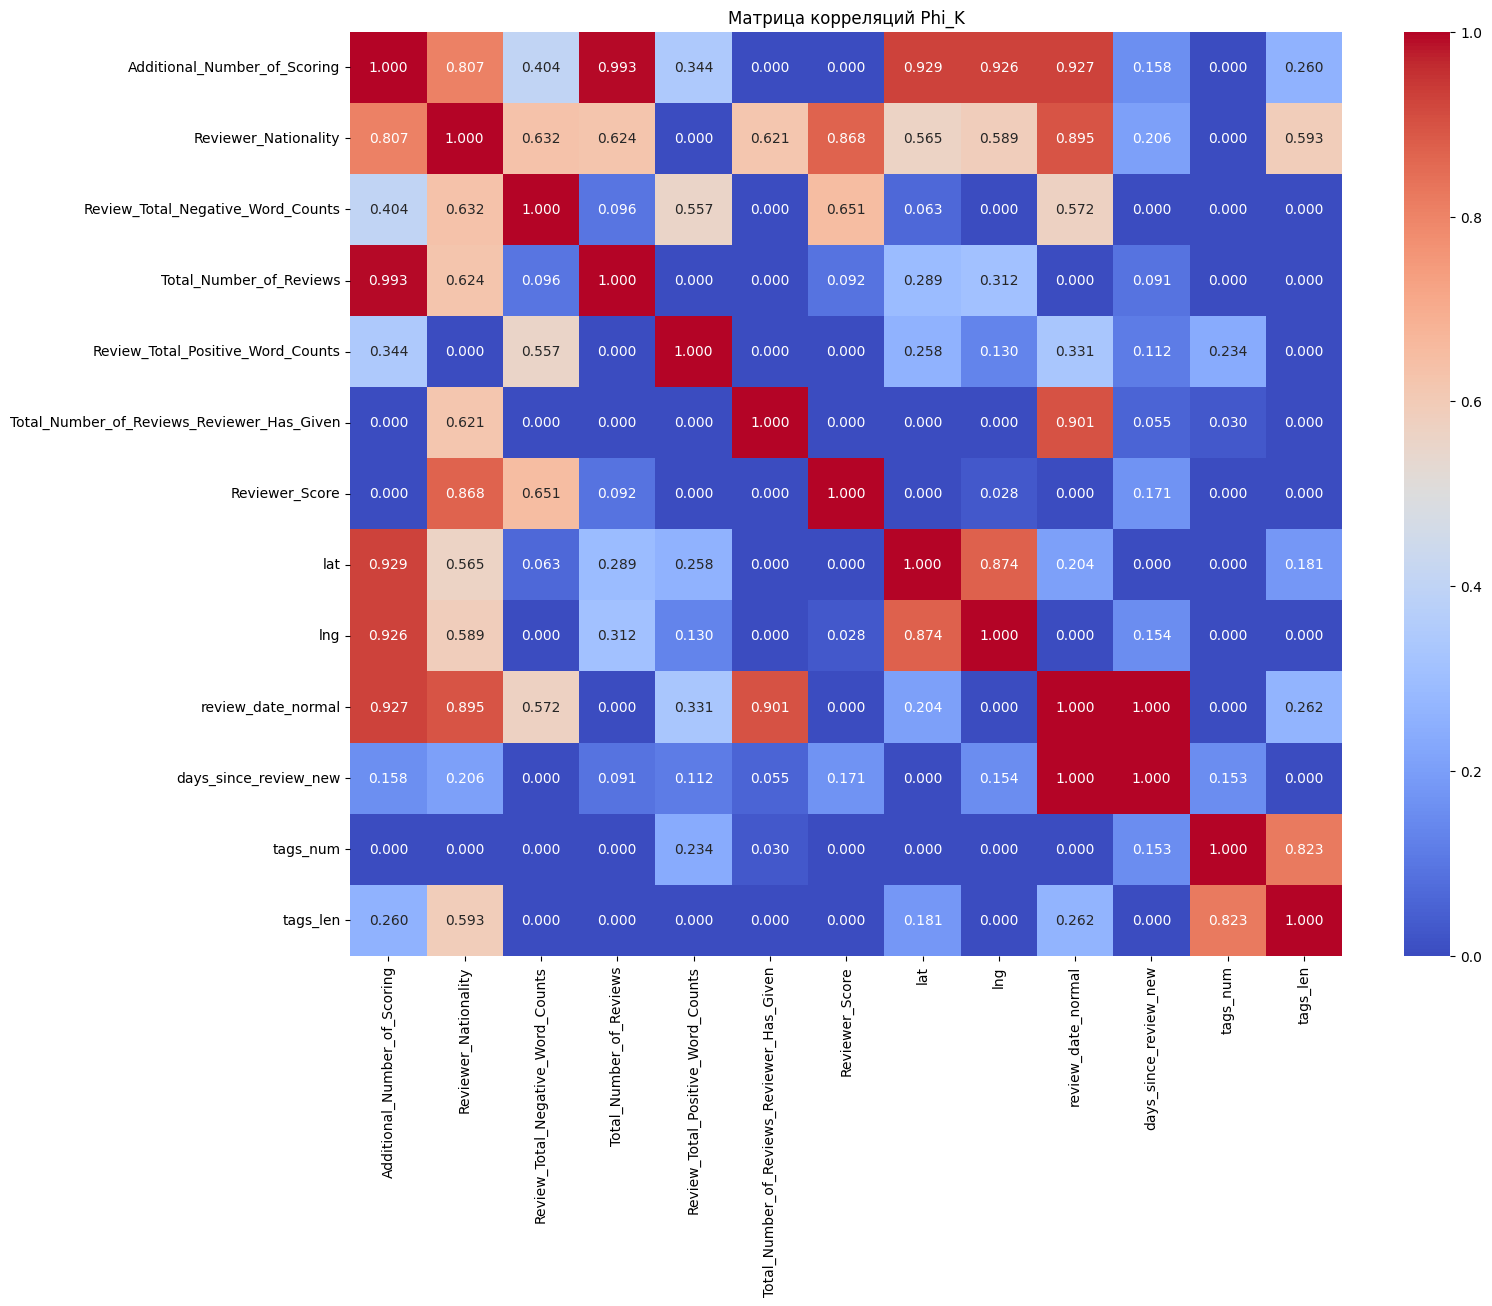

In [363]:
# Построение тепловой карты методом sns.heatmap()
plt.figure(figsize=(16, 12))
sns.heatmap(f_corr_matr, annot=True, cmap='coolwarm', fmt='.3f')
#plt.xticks(rotation=45)
plt.title('Матрица корреляций Phi_K')
plt.show()

In [364]:
df_train_3.head()

,Additional_Number_of_Scoring,Reviewer_Nationality,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng,review_date_normal,days_since_review_new,tags_num,tags_len
0,170,United Kingdom,72,1593,8,1,5.4,52.400181,4.893665,2017-04-17,108,5,109
1,114,Malaysia,246,995,41,1,9.6,52.349743,4.891191,2016-05-26,434,5,109
2,1195,United Kingdom,19,4684,19,3,8.8,51.491374,-0.121419,2016-12-04,242,5,121
3,111,Oman,14,865,5,21,10.0,48.216315,16.368510,2017-04-30,95,5,104
4,147,United Kingdom,3,1562,11,1,9.2,41.385817,2.125679,2017-01-22,193,4,96


In [365]:
columns_to_drop = ['days_since_review_new']

In [366]:
df_train_for_model = df_train_3.drop(columns_to_drop, axis=1)
df_train_for_model_small, _ = train_test_split(
    df_train_for_model,
    train_size=500,
    stratify=df_train_for_model['Reviewer_Score'],
    random_state=RANDOM_STATE
)

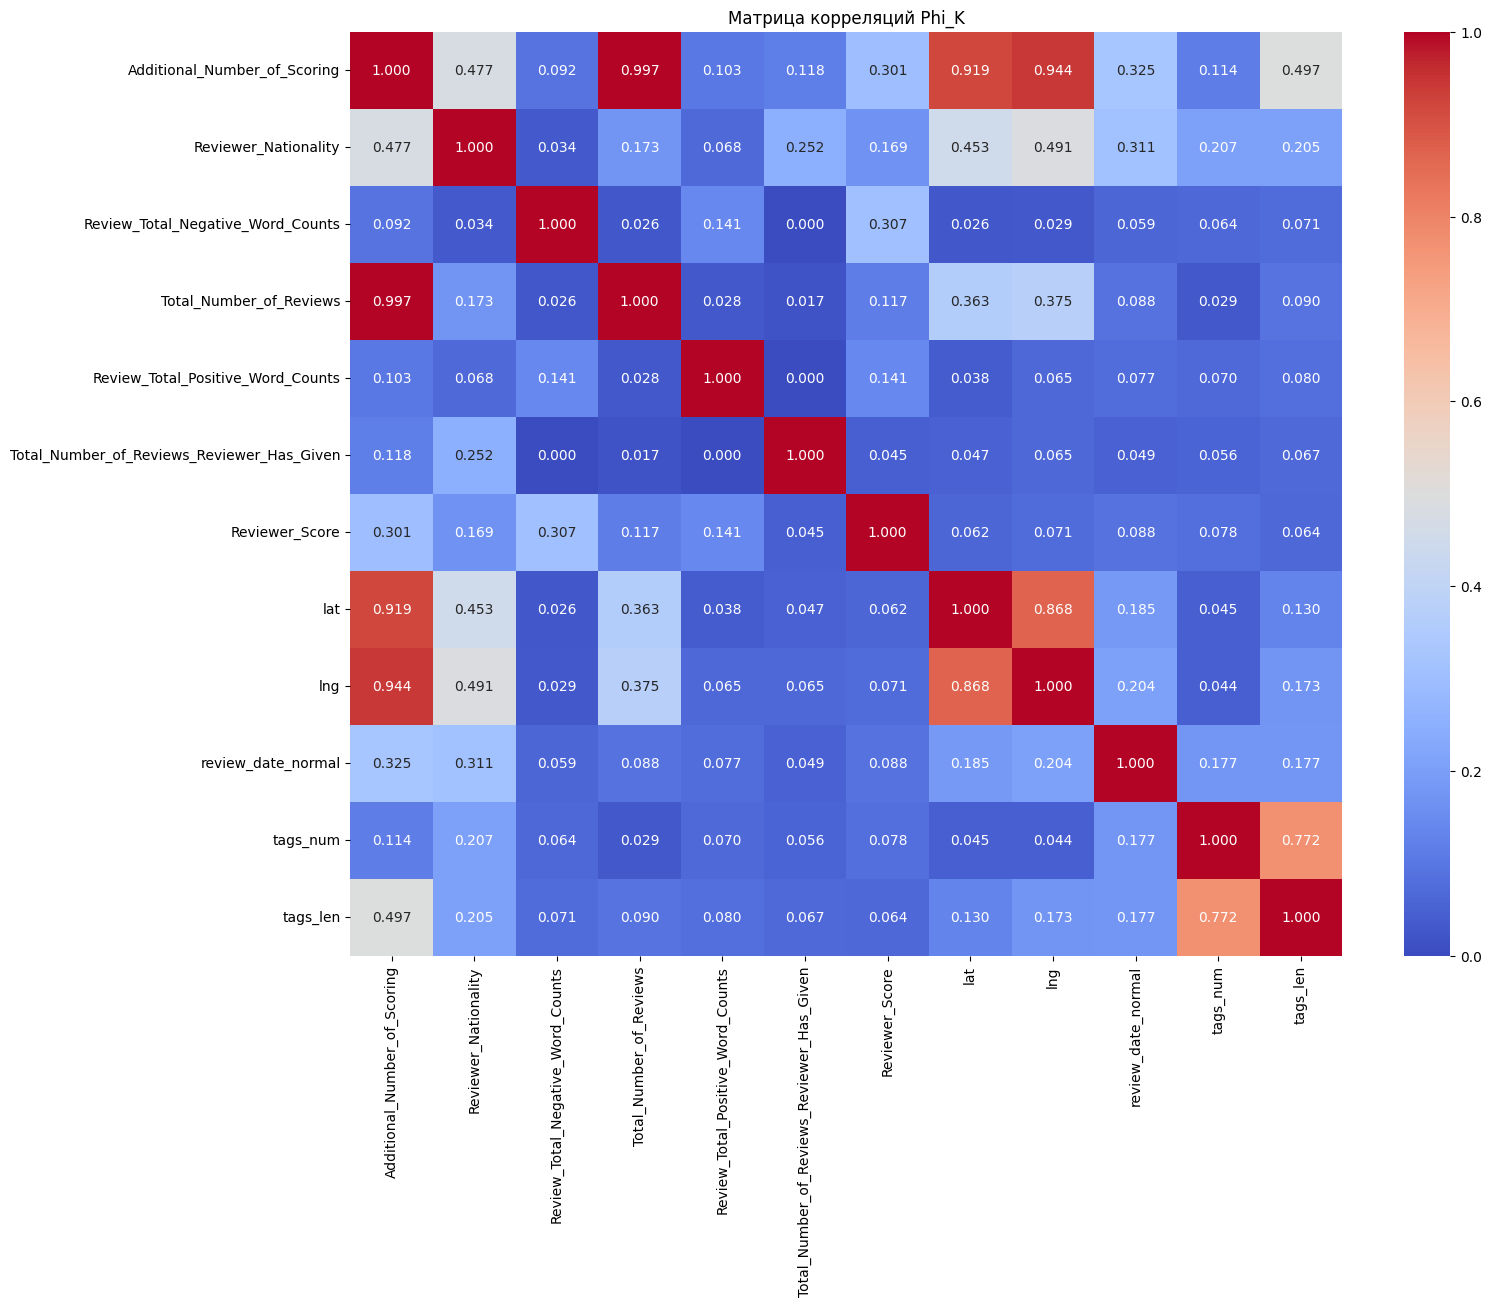

In [367]:
f_corr_matr_model = df_train_for_model.phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(16, 12))
sns.heatmap(f_corr_matr_model, annot=True, cmap='coolwarm', fmt='.3f')
#plt.xticks(rotation=45)
plt.title('Матрица корреляций Phi_K')
plt.show()

<a id='Step6'></a>
<h3><b>6. Обучение модели и получение результатов <a class="tocSkip"></h3>

<a id='Step6.1'></a>
<h4><b> 6.1 Подготовка признаков<a class="tocSkip"></h4>

In [368]:
#Переименовываем значения категорий, чтобы не было ошибок для LGBMClassifier
import re
df_train_for_model = df_train_for_model.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [369]:
df_train_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412590 entries, 0 to 412589
Data columns (total 13 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Additional_Number_of_Scoring                412590 non-null  int64         
 1   Reviewer_Nationality                        412590 non-null  object        
 2   Review_Total_Negative_Word_Counts           412590 non-null  int64         
 3   Total_Number_of_Reviews                     412590 non-null  int64         
 4   Review_Total_Positive_Word_Counts           412590 non-null  int64         
 5   Total_Number_of_Reviews_Reviewer_Has_Given  412590 non-null  int64         
 6   Reviewer_Score                              412590 non-null  float64       
 7   lat                                         409990 non-null  float64       
 8   lng                                         409990 non-null  float64      

In [380]:
#Создаим списки с распределением столбов для кодирования

#num_columns = df_train_for_model.select_dtypes(include='number').columns.tolist()
num_columns = ['Additional_Number_of_Scoring', 'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews', 'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'lat', 'lng', 'tags_num', 'tags_len']
ohe_columns = ['Reviewer_Nationality'] #'country_code_to_plot', 
#Отделим входные признаки от целевого признака#, 'region'
X_train = df_train_for_model.drop(['Reviewer_Score'], axis=1)
y_train = df_train_for_model['Reviewer_Score']

In [381]:
X_train.sample()

,Additional_Number_of_Scoring,Reviewer_Nationality,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,lat,lng,review_date_normal,tags_num,tags_len
351116,950,United Kingdom,3,3486,6,2,51.506472,-0.071689,2017-07-07,5,126


In [382]:
num_columns

['Additional_Number_of_Scoring',
 'Review_Total_Negative_Word_Counts',
 'Total_Number_of_Reviews',
 'Review_Total_Positive_Word_Counts',
 'Total_Number_of_Reviews_Reviewer_Has_Given',
 'lat',
 'lng',
 'tags_num',
 'tags_len']

In [383]:
#Укрупним категории
# Ограничение количества уникальных категорий для ускорения One-Hot Encoding
top_n = 15  # Количество топ категорий для каждого признака
for col in ohe_columns:
    top_categories = X_train[col].value_counts().nlargest(top_n).index
    X_train[col] = X_train[col].apply(lambda x: x if x in top_categories else 'Other')

In [384]:
imputer = SimpleImputer(
    missing_values=np.nan,
    strategy='most_frequent'
    )
imputer.fit(X_train)
X_train[imputer.feature_names_in_] = imputer.transform(X_train)

In [385]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse_output=False, drop='first')

# обучите и преобразуйте категориальные признаки из тренировочной и тестовой выборок 
# для тренировочной выборки сделайте это одной командой
X_train_ohe = ohe.fit_transform(X_train[ohe_columns])
#X_test_ohe = ohe.transform(X_test[ohe_columns])

# сохраните в переменной encoder_col_names список названий новых столбцов 
encoder_col_names = ohe.get_feature_names_out()

# создайте датафрейм из закодированных данных
# передайте названия столбцов из переменной encoder_col_names
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
#X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

# масштабируйте количественные признаки из тренировочной и тестовой выборок 
# для тренировочной выборки сделайте это одной командой
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
#X_test[num_col_names] = scaler.transform(X_test[num_col_names])

# обнулите индексы строк перед объединением числовых и категориальных признаков в датафрейм
X_train = X_train.reset_index(drop=True)
#X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_train = pd.concat((X_train[num_columns], X_train_ohe), axis=1)
#X_test = pd.concat((X_test[num_col_names], X_test_ohe), axis=1)
# Отбор признаков с помощью SelectKBest

selector = SelectKBest(score_func=mutual_info_regression, k=20)
X_selected = selector.fit_transform(X_train, y_train)

## Получение названий выбранных признаков
selected_indices = selector.get_support(indices=True)
selected_feature_names = X_train.columns[selected_indices]

X_train_final = pd.DataFrame(X_selected, columns=selected_feature_names)

In [386]:
X_train_final.head()

,Additional_Number_of_Scoring,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,lat,lng,tags_num,tags_len,Reviewer_Nationality_ Canada,Reviewer_Nationality_ Germany,Reviewer_Nationality_ Ireland,Reviewer_Nationality_ Netherlands,Reviewer_Nationality_ Saudi Arabia,Reviewer_Nationality_ Switzerland,Reviewer_Nationality_ Turkey,Reviewer_Nationality_ United Arab Emirates,Reviewer_Nationality_ United Kingdom,Reviewer_Nationality_ United States of America,Reviewer_Nationality_Other
0,-0.655314,1.801822,-0.496661,-0.448832,-0.557672,0.851185,0.456512,0.826915,0.310452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.767193,7.667613,-0.754491,1.063527,-0.557672,0.836614,0.455971,0.826915,0.310452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.392462,0.015116,0.836034,0.055288,-0.376797,0.588646,-0.641640,0.826915,0.878666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.773186,-0.153442,-0.810541,-0.586320,1.251085,-0.357462,2.969158,0.826915,0.073696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.701265,-0.524267,-0.510027,-0.311345,-0.557672,-2.330675,-0.149593,-1.095588,-0.305113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [387]:
# Стратегия кросс-валидации
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Определение моделей и их гиперпараметров (исключаем SVC)
models = {
#    'RandomForest': {
#        'model': RandomForestRegressor(random_state=42),
#        'params': {
#            'n_estimators': [100, 200],
#            'max_depth': [10, 20, None],
#            'min_samples_split': [2, 5]
#        }
#    },
#    'GradientBoosting': {
#        'model': GradientBoostingRegressor(random_state=42),
#        'params': {
#            'n_estimators': [100, 200],
#            'learning_rate': [0.01, 0.1],
#            'max_depth': [3, 5]
#        }
#    },
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'num_leaves': [31, 50]
        }
    },
    'CatBoost': {
        'model': cb.CatBoostRegressor(verbose=0, random_state=42),
        'params': {
            'iterations': [100, 200],
            'learning_rate': [0.01, 0.1],
            'depth': [6, 10]
        }
    }
}

<a id='Step6.2'></a>
<h4><b> 6.2 Обучение модели<a class="tocSkip"></h4>

In [388]:
# Словарь для хранения лучших моделей и их оценок
best_models = {}
best_scores = {}

# Обучение и подбор гиперпараметров для каждой модели
for name, config in models.items():
    print(f"Обучение модели: {name}")
    grid_search = RandomizedSearchCV(
        estimator=config['model'],
        param_distributions=config['params'],
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
        #error_score='raise'
    )
    grid_search.fit(X_train_final, y_train)
    best_models[name] = grid_search.best_estimator_
    best_scores[name] = grid_search.best_score_
    print(f"Лучшая оценка MAPE score: {grid_search.best_score_:.4f}")
    print(f"Лучшие параметры: {grid_search.best_params_}\n")

# Вывод лучших моделей и их MAPE
print("Лучшие модели и их оценки MAPE score:")
for name, score in best_scores.items():
    print(f"{name}: MAPE = {score:.4f}")

Обучение модели: LinearRegression
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Лучшая оценка MAPE score: -1.1105
Лучшие параметры: {}

Обучение модели: XGBoost
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшая оценка MAPE score: -0.9255
Лучшие параметры: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}

Обучение модели: LightGBM
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 412590, number of used features: 20
[LightGBM] [Info] Start training from score 8.395058
Лучшая оценка MAPE score: -0.9190
Лучшие параметры: {'num_leaves': 50, 'n_estima

<a id='Step6.3'></a>
<h4><b> 6.3 Применение модели на тестовой выборке<a class="tocSkip"></h4>

In [389]:
X_train_final.columns

Index(['Additional_Number_of_Scoring', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'lat', 'lng', 'tags_num',
       'tags_len', 'Reviewer_Nationality_ Canada ',
       'Reviewer_Nationality_ Germany ', 'Reviewer_Nationality_ Ireland ',
       'Reviewer_Nationality_ Netherlands ',
       'Reviewer_Nationality_ Saudi Arabia ',
       'Reviewer_Nationality_ Switzerland ', 'Reviewer_Nationality_ Turkey ',
       'Reviewer_Nationality_ United Arab Emirates ',
       'Reviewer_Nationality_ United Kingdom ',
       'Reviewer_Nationality_ United States of America ',
       'Reviewer_Nationality_Other'],
      dtype='object')

In [390]:
df_test_for_model = df_test_3.drop(columns_to_drop, axis=1)

In [393]:
# Ограничение количества уникальных категорий для ускорения One-Hot Encoding
top_n = 15  # Количество топ категорий для каждого признака
for col in ohe_columns:
    #top_categories = df_test_for_model[col].value_counts().nlargest(top_n).index
    df_test_for_model[col] = df_test_for_model[col].apply(lambda x: x if x in top_categories else 'Other')

In [403]:
df_test_for_model.sample()

,Additional_Number_of_Scoring,Reviewer_Nationality,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,lat,lng,review_date_normal,tags_num,tags_len
66344,204,Other,31,812,23,7,51.493475,-0.215326,2017-04-19,5,119


In [411]:
X_test = df_test_for_model.copy()

In [412]:
X_test[imputer.feature_names_in_] = imputer.transform(X_test)

In [413]:
imputer.feature_names_in_

array(['Additional_Number_of_Scoring', 'Reviewer_Nationality',
       'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'lat', 'lng',
       'review_date_normal', 'tags_num', 'tags_len'], dtype=object)

In [414]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103148 entries, 0 to 103147
Data columns (total 11 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Additional_Number_of_Scoring                103148 non-null  object        
 1   Reviewer_Nationality                        103148 non-null  object        
 2   Review_Total_Negative_Word_Counts           103148 non-null  object        
 3   Total_Number_of_Reviews                     103148 non-null  object        
 4   Review_Total_Positive_Word_Counts           103148 non-null  object        
 5   Total_Number_of_Reviews_Reviewer_Has_Given  103148 non-null  object        
 6   lat                                         103148 non-null  object        
 7   lng                                         103148 non-null  object        
 8   review_date_normal                          103148 non-null  datetime64[ns

In [415]:
X_test_ohe = ohe.transform(X_test[ohe_columns])
encoder_col_names = ohe.get_feature_names_out()

X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_test[num_columns] = scaler.transform(X_test[num_columns])
X_test = X_test.reset_index(drop=True)
X_test = pd.concat((X_test[num_columns], X_test_ohe), axis=1)

#selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_selected_test = selector.transform(X_test)

# Получение названий выбранных признаков
selected_indices_test = selector.get_support(indices=True)
selected_feature_names_test = X_test.columns[selected_indices_test]

X_test_final = pd.DataFrame(X_selected_test, columns=selected_feature_names_test)

In [416]:
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]
test_pred = best_model.predict(X_test_final)

In [417]:
# Отображаем предсказанные классы в 'operating' и 'closed'
#status_mapping = {0: 'operating', 1: 'closed'}
test_pred_labels = pd.Series(test_pred, index=X_test_final.index)
#.map(status_mapping)

In [418]:
# Создаём финальный DataFrame для отправки
result_df = pd.DataFrame({
    'id': X_test_final.index,
    'score': test_pred_labels
})

In [419]:
result_df

,id,score
0,0,9.536454
1,1,8.760165
2,2,8.395445
3,3,9.461798
4,4,8.025111
...,...,...
103143,103143,9.534311
103144,103144,9.071377
103145,103145,9.004778
103146,103146,9.473083


In [420]:
# Сохраняем файл для отправки
result_df_file_path = "result_df.csv"
result_df.to_csv(result_df_file_path, index=False)
print(f"Файл для отправки сохранён по пути: {result_df_file_path}")

Файл для отправки сохранён по пути: result_df.csv


In [276]:
# 6. Сохраняем модель для будущего использования
model_file_path = "best_model.joblib"
joblib.dump(best_model, model_file_path)
print(f"Модель сохранена по пути: {model_file_path}")

Модель сохранена по пути: best_model.joblib
